In [1]:
from model import Mlp, caption_generation
import torch
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import json
import torch.nn as nn
from clip import clip
from PIL import Image

C:\Users\a\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cpu'
dataset_name = 'COCO'
caption_features = torch.load("./feature/" + dataset_name + "/caption_features.pkl", map_location=torch.device(device))
caption_features_norm = caption_features / caption_features.norm(dim = -1, keepdim = True)

In [3]:
configuration = GPT2Config(
    n_embd=1280,
    n_layer=36,
    n_head=20,
    activation_function="gelu_new"
)
GPT_tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
GPT_tokenizer.pad_token = GPT_tokenizer.eos_token
GPT_tokenizer.cls_token = GPT_tokenizer.eos_token
GPT_tokenizer.sep_token = GPT_tokenizer.eos_token
GPT_model = GPT2LMHeadModel(configuration)
GPT_model.load_state_dict(torch.load("./checkpoint/" + dataset_name + "/decoder_coco.pth", map_location=torch.device(device)))

Map = Mlp()
Map.load_state_dict(torch.load("./checkpoint/" + dataset_name + "/map_coco.pth", map_location=torch.device(device)))

clip_model, preprocess = clip.load("RN50x64", device = device)

Init tokenizer
Init decoder


In [4]:
image_path = "./example/COCO_val2014_000000353830.jpg"
ori_image = Image.open(image_path)
image = preprocess(ori_image).unsqueeze(0).to(device)
image_feature = clip_model.encode_image(image)
image_feature = image_feature / image_feature.norm(dim = -1, keepdim = True)
similarity = image_feature.float() @ caption_features_norm.float().T
niber = []
for k in range(5):
    _, max_id = torch.max(similarity, dim = 1)
    niber.append(caption_features[max_id.item()].unsqueeze(0))
    similarity[0][max_id.item()] = 0

niber = torch.cat(niber).unsqueeze(0)
niber = Map(niber.float())
candidate = caption_generation(niber, GPT_model, GPT_tokenizer, device)

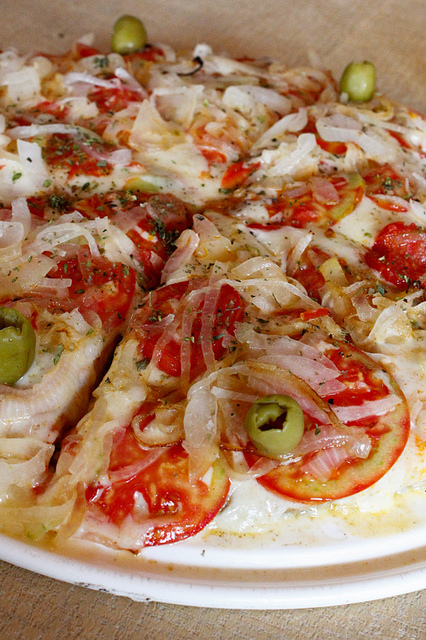

a pizza with tomatoes, cheese and olives


In [5]:
display(ori_image)
print(candidate)